In [1]:
#import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Input, Flatten, Dense, ReLU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from ultralytics import YOLO
from keras.callbacks import ModelCheckpoint

from PIL import Image

from tensorflow.keras.applications import VGG19 as vgg

from matplotlib.pyplot import imshow


In [10]:
#read the data
#The data is read from the directory and each batch can be thought of as a set of labels and datapoints
#Might need to change the directory depending on where

#Seed 50 is decent performing
train = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces updated',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
    validation_split = 0.2,
    subset = 'training',
    seed = 42    
    )

validation = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces updated',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
    validation_split = 0.2,
    subset = 'validation',
    seed = 42   
    )

Found 164 files belonging to 3 classes.
Using 132 files for training.
Found 164 files belonging to 3 classes.
Using 32 files for validation.


In [20]:
print(train.class_names)

['Negative', 'Neutral', 'Positive']


In [11]:
train_processed = train.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

validation_processed = validation.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

In [12]:

train_processed_numpy = train.as_numpy_iterator()
validation_processed_numpy = validation.as_numpy_iterator()

X_train, y_train = train_processed_numpy.next()
X_val, y_val = validation_processed_numpy.next()

2024-04-18 12:45:53.017082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [132]
	 [[{{node Placeholder/_4}}]]
2024-04-18 12:45:53.018336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [132]
	 [[{{node Placeholder/_0}}]]
2024-04-18 12:45:53.055384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [32]
	 [[

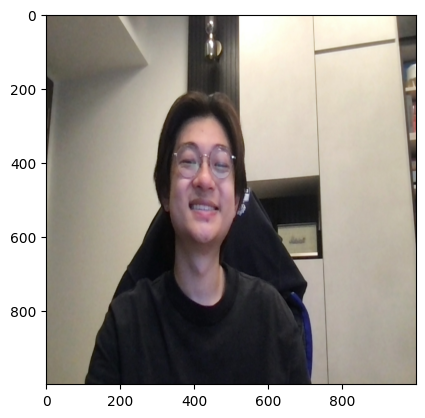

In [14]:
from collections import Counter
Counter(y_val.argmax(axis = 1))

Counter({1: 15, 2: 10, 0: 7})

In [15]:
#convert the images to cropped faces
face_classifier = YOLO("../../app/src/face_detection/model/yolov8n-face.pt")

X_cropped_train = []
y_train_cropped = []

n_train = X_train.shape[0]
for i in range(n_train):
    face = X_train[i]
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((200, 200))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_cropped_train.append(numpy_cropped_face)
        y_train_cropped.append(y_train[i])

X_val_cropped = []
y_val_cropped = []
n_val = X_val.shape[0]

for i in range(n_val):
    face = X_val[i]
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face))
        pil_face = pil_face.resize((200, 200))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_val_cropped.append(numpy_cropped_face)
        y_val_cropped.append(y_val[i])



0: 640x640 1 face, 415.6ms
Speed: 29.0ms preprocess, 415.6ms inference, 26.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 435.8ms
Speed: 11.7ms preprocess, 435.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 266.4ms
Speed: 3.5ms preprocess, 266.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 354.9ms
Speed: 2.9ms preprocess, 354.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 425.7ms
Speed: 2.5ms preprocess, 425.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 290.3ms
Speed: 2.3ms preprocess, 290.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 299.4ms
Speed: 3.1ms preprocess, 299.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 320.4ms
Speed: 3.9ms preprocess, 320.4ms inference, 0.4ms postprocess per ima

In [16]:
X_train.shape

(132, 1000, 1000, 3)

In [17]:
X_cropped_train = np.array(X_cropped_train)
print(X_cropped_train.shape)
y_train_cropped = np.array(y_train_cropped)

X_cropped_val = np.array(X_val_cropped)
print(X_cropped_val.shape)
y_val_cropped = np.array(y_val_cropped)

(121, 48, 48, 3)
(28, 48, 48, 3)


In [3]:
#flatten the output
inputs = Input(shape=(48, 48, 3))

#set inference mode to be false, flatten the output and add dense layers before making the final prediction
vgg_output = keras.applications.VGG19(input_tensor=inputs,                                      
    include_top=False,
    weights="imagenet",

    input_shape=(48, 48, 3),
    pooling=None,


)
for layer in vgg_output.layers:
    layer.trainable = False
flatten = Flatten()(vgg_output.output)
dense1 = Dense(256, activation = 'relu', name = 'first_dense_layer')(flatten)
dropout1 = Dropout(0.25)(dense1)
batch_norm1 = BatchNormalization(name = 'batch_norm1')(dropout1)
dense2 = Dense(256, activation = 'relu', name = 'second_dense_layer')(batch_norm1)
dropout2 = Dropout(0.25)(dense2)
batch_norm1 = BatchNormalization(name = 'batch_norm2')(dropout2)
output = Dense(3, activation = 'softmax', name = 'output')(batch_norm1)
final_model = Model(inputs, output)


# In[ ]:



final_model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics = ['accuracy'])
#save the model every epoch
checkpoint = ModelCheckpoint(filepath = 'vggemotion.keras')



In [19]:
final_model.fit(x=X_cropped_train,y= y_train_cropped, validation_data = (X_cropped_val, y_val_cropped), epochs=40)


# In[ ]:


final_model.save('vggemotion_final.keras')

Epoch 1/40


2024-04-18 12:48:01.250125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-04-18 12:48:01.428075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


4/4 [==============================] - ETA: 0s - loss: 1.3625 - accuracy: 0.4132

2024-04-18 12:48:05.197373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 6s 585ms/step - loss: 1.3625 - accuracy: 0.4132 - val_loss: 2.2046 - val_accuracy: 0.4643
Epoch 2/40
4/4 [==============================] - 0s 81ms/step - loss: 0.8763 - accuracy: 0.5702 - val_loss: 2.2191 - val_accuracy: 0.5714
Epoch 3/40
4/4 [==============================] - 0s 70ms/step - loss: 0.7934 - accuracy: 0.6694 - val_loss: 1.8751 - val_accuracy: 0.6786
Epoch 4/40
4/4 [==============================] - 0s 61ms/step - loss: 0.7155 - accuracy: 0.7273 - val_loss: 1.6191 - val_accuracy: 0.6786
Epoch 5/40
4/4 [==============================] - 0s 62ms/step - loss: 0.6641 - accuracy: 0.7355 - val_loss: 1.5132 - val_accuracy: 0.7143
Epoch 6/40
4/4 [==============================] - 0s 65ms/step - loss: 0.5598 - accuracy: 0.7851 - val_loss: 1.4682 - val_accuracy: 0.7143
Epoch 7/40
4/4 [==============================] - 0s 61ms/step - loss: 0.5503 - accuracy: 0.7273 - val_loss: 1.4665 - val_accuracy: 0.6429
Epoch 8/40
4/4 [=====================

# Try the above but without face croppings


In [2]:
#read the data
#The data is read from the directory and each batch can be thought of as a set of labels and datapoints
#Might need to change the directory depending on where


#Reduce the image size to facilitate the 
train = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces updated',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(500, 500),
    validation_split = 0.2,
    subset = 'training',
    seed = 42    
    )

validation = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces updated',
    labels='inferred',
    label_mode='categorical',
    batch_size=16,
    image_size=(500, 500),
    validation_split = 0.2,
    subset = 'validation',
    seed = 42   
    )

Found 164 files belonging to 3 classes.
Using 132 files for training.
Found 164 files belonging to 3 classes.
Using 32 files for validation.


In [4]:
train_processed = train.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

validation_processed = validation.map(lambda x, y: (keras.applications.vgg19.preprocess_input(x), y))

In [5]:

inputs = Input(shape=(500, 500, 3))

#set inference mode to be false, flatten the output and add dense layers before making the final prediction
vgg_output = keras.applications.VGG19(input_tensor=inputs,                                      
    include_top=False,
    weights="imagenet",

    input_shape=(500, 500, 3),
    pooling=None,


)
for layer in vgg_output.layers:
    layer.trainable = False
flatten = Flatten()(vgg_output.output)
dense1 = Dense(256, activation = 'relu', name = 'first_dense_layer')(flatten)
dropout1 = Dropout(0.25)(dense1)
batch_norm1 = BatchNormalization(name = 'batch_norm1')(dropout1)
dense2 = Dense(256, activation = 'relu', name = 'second_dense_layer')(batch_norm1)
dropout2 = Dropout(0.25)(dense2)
batch_norm1 = BatchNormalization(name = 'batch_norm2')(dropout2)
output = Dense(3, activation = 'softmax', name = 'output')(batch_norm1)
final_model = Model(inputs, output)


# In[ ]:



final_model.compile(optimizer = 'adam', loss = CategoricalCrossentropy(), metrics = ['accuracy'])
#save the model every epoch
checkpoint = ModelCheckpoint(filepath = 'vggemotion.keras')



In [6]:
final_model.fit(train_processed, validation_data = validation_processed, epochs=20)


# In[ ]:


final_model.save('vggemotion.keras')

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 150s 16s/step - accuracy: 0.4326 - loss: 1.5107 - val_accuracy: 0.5312 - val_loss: 1.7468
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 139s 16s/step - accuracy: 0.6042 - loss: 1.0404 - val_accuracy: 0.5312 - val_loss: 1.6568
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 127s 14s/step - accuracy: 0.6176 - loss: 0.8564 - val_accuracy: 0.5000 - val_loss: 1.8664
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 131s 15s/step - accuracy: 0.8159 - loss: 0.5340 - val_accuracy: 0.6250 - val_loss: 1.3323
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 134s 15s/step - accuracy: 0.7896 - loss: 0.4659 - val_accuracy: 0.6562 - val_loss: 0.9237
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 136s 16s/step - accuracy: 0.8280 - loss: 0.4992 - val_accuracy: 0.6875 - val_loss: 0.7220
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 122s 13s/step - accuracy: 0.8438 - loss: 0.3917 - val_accuracy: 0.7188 - val_loss: 0.6836
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 137s 16s/step - accuracy: 0.8269 - loss: 0.3304 - val_accuracy: 0.7188 - val_loss:

# Final model deployment code

Since this model performs the best, we train a final model that makes use of all the datapoints in our dataset and deploy this model